# Lab 4

#### Integrantes:
>- Víctor Saez
>- Miguel Escobar 

## Ejercicio 1

Para la matriz $U$, como queremos que $\mathbf{u}^T U \mathbf{u} = ||\mathbf{u}||$, entonces $U$ debe ser la identidad.

Para la matriz $W$, debe ser nula, pues el integrando no depende de $x$.

La matriz $K$, por otro lado, debe extraer los componentes de la velocidad en nuestro sistema. Recordemos que escribimos el sistema como sigue:

$$
\mathbf{x}(t) = 
\left(
\begin{array}{c}
x(t)\\
\dot{x}(t)\\
y(t)\\
\dot{y}(t)\\
z(t)
\end{array}
\right);
\quad
A = 
\begin{bmatrix} 
0 & 1 & 0 & 0 & 0 \\ 
1 & 0 & 0 & 0 & 0 \\ 
0 & 0 & 0 & 1 & 0 \\ 
0 & 0 & 1 & 0 & 0 \\ 
1 & 0 & 1 & 0 & 0 \ 
\end{bmatrix};
\quad
B = 
\begin{bmatrix}
0 & 0 \\
1 & 0 \\
0 & 0 \\
0 & 1 \\
0 & 0 \\
\end{bmatrix};
\quad
\mathbf{u}(t) =
\left(
\begin{array}{c}
u(t)\\
v(t)\\
\end{array}
\right).
$$

Luego, la matriz $Q$ debe ser:

$$
Q = \frac{m}{2}
\begin{bmatrix} 
1 & 0 & 1 & 0 & 0 \\ 
0 & 1 & 0 & 0 & 0 \\ 
1 & 0 & 1 & 0 & 0 \\ 
0 & 0 & 0 & 1 & 0 \\ 
0 & 0 & 0 & 0 & 0 \\
\end{bmatrix}
$$

Notemos que $Q$ es simétrica, y semidefinida positiva (sus autovaleros son $0$, $1$, y $2$). $U$ es la identidad, por lo que es simétrica definida positiva. $W$ es nula, entonces es simétrica semidefinida positiva. Cumplen las hipótesis del problema lineal cuadrático. (Note: Todas son constantes luego están en sus respectivos $L^\infty_{loc}$)




## Ejercicio 3

Notemos primero que podemos escribir todo el problema, y su dinámica, $x, y$ sin usar la coordenada $z$. Podríamos considerar un problema simplificado entonces para la evolución de $x$ e $y$.

In [65]:
import numpy as np
from scipy.integrate import solve_ivp, trapezoid
from scipy.optimize import minimize

# Escribo las matrices A y B del sistema sin la última coordenada:

A = np.array([[0, 1, 0, 0],
              [1, 0, 0, 0],
              [0, 0, 0, 1],
              [0, 0, 1, 0]])

B = np.array([[0, 0],
              [1, 0],
              [0, 0],
              [0, 1]])

Q = np.array([[1, 0, 1, 0], 
              [0, 1, 0, 0], 
              [1, 0, 1, 0], 
              [0, 0, 0, 1]])

BBT = B @ B.T

xinit = np.array([1, 0, 1, 0])

def rhs(t, r):
    x = r[:4]
    p = r[4:]
    xresult = A @ x + BBT @ p
    presult = -A @ p
    result = np.concatenate((xresult, presult))
    assert result.shape == r.shape
    return result

def objective(p_init):
    r_init = np.concatenate((xinit, p_init))
    sol = solve_ivp(rhs, [0, 5], r_init, t_eval=[5], max_step=0.01)
    xfinal = sol.y[:4, -1]
    pfinal = sol.y[4:, -1]
    objective_p = -.5*Q @ xfinal
    return np.linalg.norm(pfinal - objective_p)**2

p_init = np.array([1, 1, 1, 1])

res = minimize(objective, p_init, options={'disp': True})
p_init_opt = res.x
print("p_opt = ", p_init_opt)

# Recuperamos las trayectorias óptimas:
t_eval, dt = np.linspace(0, 5, 1001, endpoint=True, retstep=True)
scipy_solution = solve_ivp(rhs, [0, 5], np.concatenate((xinit, p_init_opt)), t_eval=t_eval)

# Estimamos el costo final:
x_opt = scipy_solution.y[:4, :]
u_opt = B.T @ scipy_solution.y[4:, :]
u_norm = np.linalg.norm(u_opt, axis=0)
final_kinetic_energy = .5 * (x_opt[1, -1]**2 + x_opt[3, -1]**2 + (x_opt[0, -1] + x_opt[2, -1])**2)
force_cost = trapezoid(u_norm**2, scipy_solution.t)

final_cost = final_kinetic_energy + force_cost


print(f"\nEl costo final que obtuvimos es: {final_cost}")


# Recuperamos z_opt a partir de x_opt e y_opt:

z_opt = np.zeros(len(x_opt[0, :]))
for i, r in enumerate(x_opt.T):
    if i == 0:
        pass
    else:
        z_opt[i] = z_opt[i-1] + (r[0] + r[2]) * dt

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
p_opt =  [-2.00174046 -2.0014028  -2.00174046 -2.0014028 ]

El costo final que obtuvimos es: 4.003450101415328


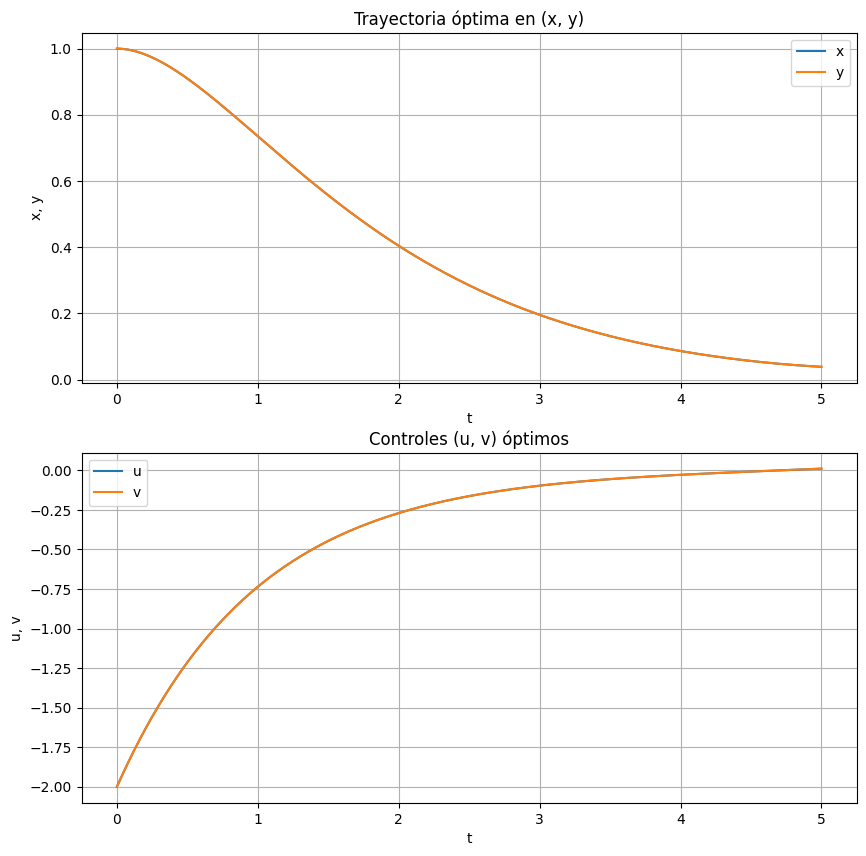

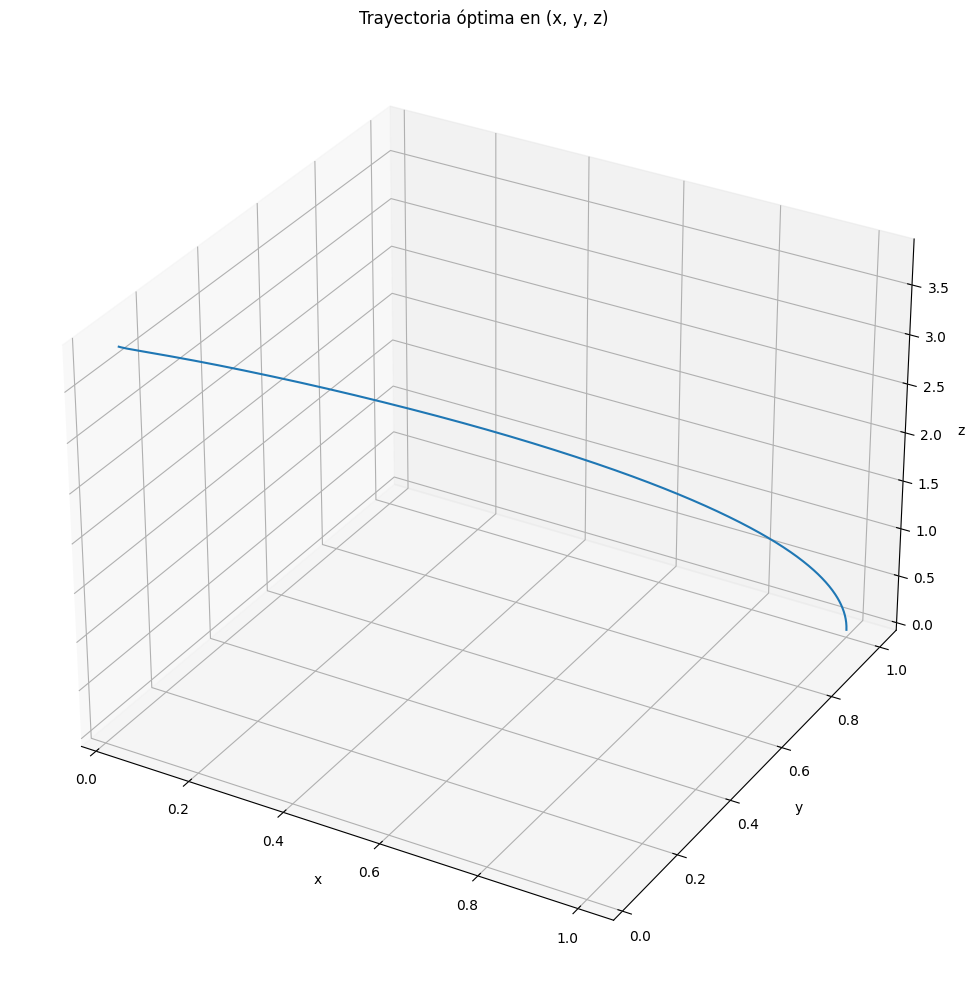

In [66]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].set_title('Trayectoria óptima en (x, y)')
ax[0].plot(scipy_solution.t, scipy_solution.y[0])
ax[0].plot(scipy_solution.t, scipy_solution.y[2])
ax[0].set_xlabel('t')
ax[0].set_ylabel('x, y')
ax[0].legend(['x', 'y'])
ax[0].grid()

ax[1].set_title('Controles (u, v) óptimos')
ax[1].plot(scipy_solution.t, scipy_solution.y[5])
ax[1].plot(scipy_solution.t, scipy_solution.y[7])
ax[1].set_xlabel('t')
ax[1].set_ylabel('u, v')
ax[1].legend(['u', 'v'])
ax[1].grid()

plt.show()

fig3d = plt.figure(figsize=(10, 10))
ax3d = fig3d.add_subplot(projection='3d')
ax3d.set_title('Trayectoria óptima en (x, y, z)')
ax3d.plot(scipy_solution.y[0], scipy_solution.y[2], z_opt)
ax3d.set_xlabel('x')
ax3d.set_ylabel('y')
ax3d.set_zlabel('z')
ax3d.grid()
fig3d.tight_layout()
plt.show()

## Ejercicio 4

4.006224340385105


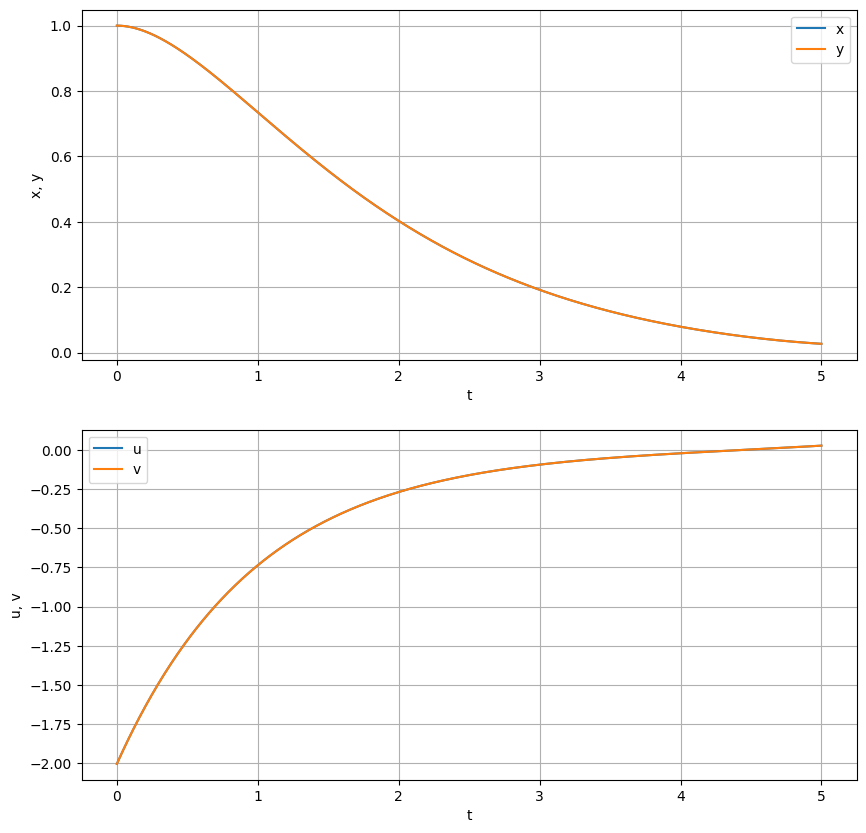

In [67]:
W = np.zeros((4, 4))

def ricattirhs(t, E_flattened):
    E = E_flattened.reshape((4, 4))
    res = (W - A.T @ E - E.T @ A - E.T @ BBT @ E)
    return res.reshape(16)

E5 = (-Q).reshape(16)
sol = solve_ivp(ricattirhs, [5, 0], E5, t_eval=np.linspace(5, 0, 1001, endpoint=True), vectorized=True, dense_output=True)

E0 = sol.sol(0).reshape((4, 4))

cost = -xinit @ E0 @ xinit

print(cost)

def ricatti_system(t, xz, Esol):
    E = Esol(t).reshape((4, 4))
    x = xz[:4]
    z = xz[4:]
    xresult = A @ x + BBT @ E @ x
    zresult = x[0] + x[2]
    result = np.concatenate((xresult, [zresult]))
    return result

xzinit = np.concatenate((xinit, [0]))
ricatti_sol = solve_ivp(ricatti_system, [0, 5], xzinit, t_eval=t_eval, args=(sol.sol,))


fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(ricatti_sol.t, ricatti_sol.y[0])
ax[0].plot(ricatti_sol.t, ricatti_sol.y[2])
ax[0].set_xlabel('t')
ax[0].set_ylabel('x, y')
ax[0].legend(['x', 'y'])
ax[0].grid()

controls = np.array([B.T @ sol.sol(t).reshape((4, 4)) @ ricatti_sol.y[:4, i] for (i, t) in enumerate(t_eval)])
ax[1].plot(t_eval, controls[:, 0])
ax[1].plot(t_eval, controls[:, 1])
ax[1].set_xlabel('t')
ax[1].set_ylabel('u, v')
ax[1].legend(['u', 'v'])
ax[1].grid()

plt.show()



### Comparación con BOCOP

(1001,)


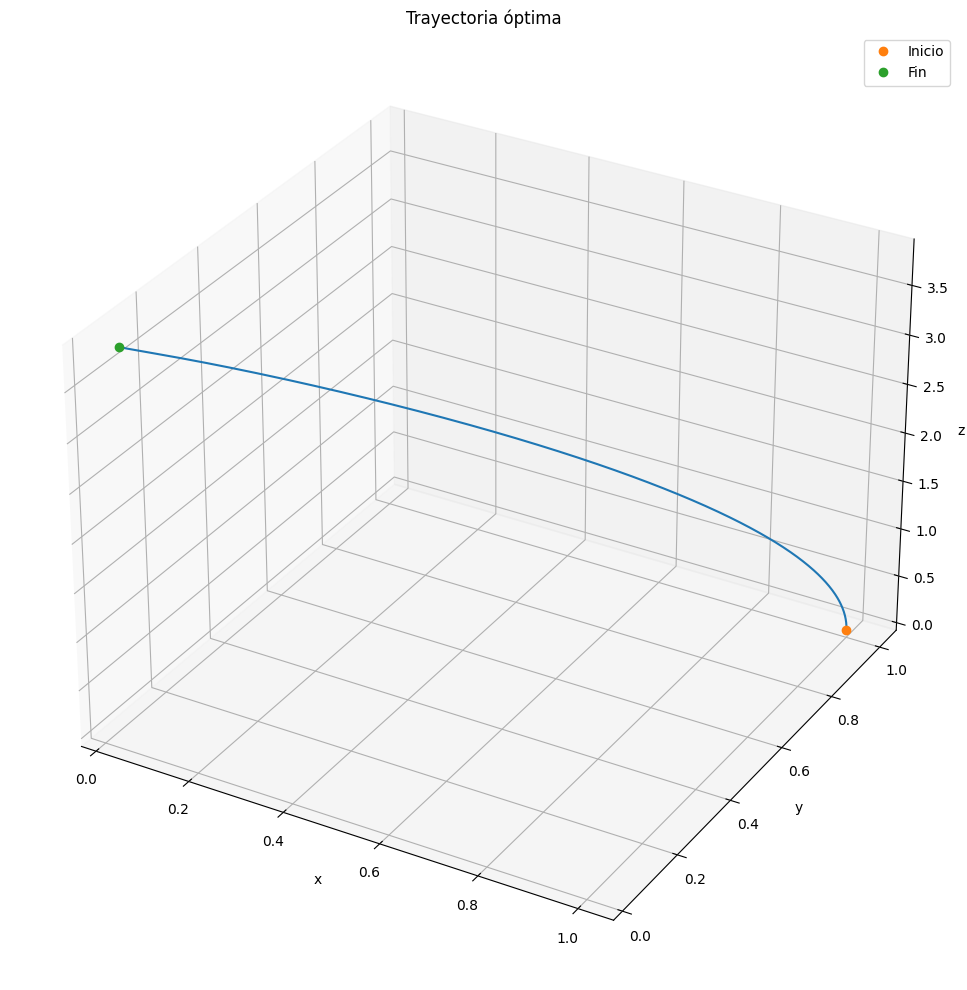

In [68]:
# Cargamos los datos exportados de BOCOP:

bocop_times = np.loadtxt('Bocop_export/discretization_times.export')
bocop_x = np.loadtxt('Bocop_export/x_position.export')
bocop_y = np.loadtxt('Bocop_export/y_position.export')
bocop_z = np.loadtxt('Bocop_export/z_position.export')
bocop_u = np.loadtxt('Bocop_export/u.export')
bocop_v = np.loadtxt('Bocop_export/v.export')
final_vx = np.loadtxt('Bocop_export/x_speed.export')[-1]
final_vy = np.loadtxt('Bocop_export/y_speed.export')[-1]

print(bocop_x.shape)
# Ploteamos la trayectoria que nos entrega:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.plot(bocop_x, bocop_y, bocop_z)
ax.plot(bocop_x[0], bocop_y[0], bocop_z[0], 'o', label='Inicio')
ax.plot(bocop_x[-1], bocop_y[-1], bocop_z[-1], 'o', label='Fin')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Trayectoria óptima')
ax.legend()
fig.tight_layout()
plt.show()

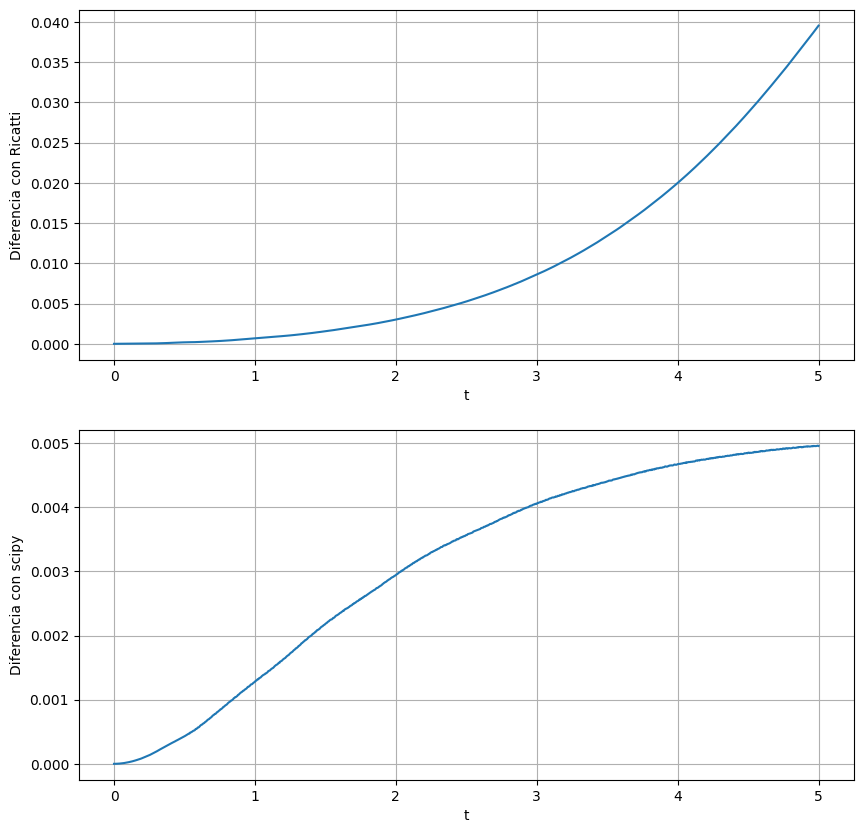

Posiciones finales:
 Ricatti: [0.02696665 0.02696665 3.84419678] 
 Scipy: [0.03851323358902138, 0.03851323358902138, 3.875223470857798] 
 Bocop: [0.0385312, 0.0385312, 3.88018]


In [69]:
# Comparamos con las trayectorias que obtuvimos con Ricatti y con scipy:

ricatti_difference = np.linalg.norm(ricatti_sol.y[[0, 2, 4], :] - np.array([bocop_x, bocop_y, bocop_z]), axis=0)
scipy_difference = np.linalg.norm(np.array([x_opt[0, :], x_opt[2, :], z_opt]) - np.array([bocop_x, bocop_y, bocop_z]), axis=0)

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(bocop_times, ricatti_difference)
ax[0].set_xlabel('t')
ax[0].set_ylabel('Diferencia con Ricatti')
ax[0].grid()

ax[1].plot(bocop_times, scipy_difference)
ax[1].set_xlabel('t')
ax[1].set_ylabel('Diferencia con scipy')
ax[1].grid()

plt.show()

print(f"Posiciones finales:\n Ricatti: {ricatti_sol.y[[0, 2, 4], -1]} \n Scipy: {[x_opt[0, -1], x_opt[2, -1], z_opt[-1]]} \n Bocop: {[bocop_x[-1], bocop_y[-1], bocop_z[-1]]}")

Observamos que la solución obtenida con BOCOP es más similar a aquella obtenida mediante scipy.minimize que mediante la ecuación de Ricatti. Sospechamos que la solución más confiable es aquella obtenida mediante scipy.minimize o bien mediante BOCOP. Esto es pues para obtener la trajectoria de Ricatti, se resolvió un sistema desde t_0 = 5 a tf = 0 y luego se utilizó esa solución para obtener otra trajectoria de t_0 = 0 a t_f = 5. Esto llevaría a al menos duplicar el error de la solución.
